<a href="https://colab.research.google.com/github/rk119/F20DL-Group14-Submissions/blob/main/Part4_UG14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 4 - Neural Networks and Convolutional Neural Networks

Neural Networks and Convolutional Neural Networks are a type of supervised learning algorithm that are used for both classification and regression tasks.


**Neural Networks (NNs)**

**Basic Concept:**

* *Layered Connections*: Neural networks are made up of layers of neurons (or nodes). Information flows from the input layer, through one or more "hidden" layers, to the output layer.

* *Processing Information*: Each neuron processes input by multiplying it with weights (learned values), sums it up, and then applies a function to determine its output.

* *Learning*: Neural networks learn by adjusting the weights to predict the correct output. They do this by comparing their prediction to the actual answer and then making adjustments.


**Convolutional Neural Networks (CNNs)**

**Basic Concept:**

* *Designed for Images*: CNNs are a type of neural network specially designed for processing data with a grid-like structure, such as images.

* *Feature Detection*: They have special layers (convolutional layers) that automatically detect important features (like edges in images) without needing to specify what to look for.

* *Reducing Complexity*: CNNs use pooling layers to reduce the size of the data, making processing faster and focusing on the most important information.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from itertools import cycle
import cv2
import random
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

### **Loading data**

In [ ]:
# Complete data path for reusability
complete_data_path = "/content/drive/MyDrive/F20DL_Data/Traffic_Sign/CompleteDataSet/"
# complete_data_path = "G:/My Drive/F20DL_Data/Traffic_Sign/CompleteDataSet/"

# X (Attributes) train file
x_train_all = pd.read_csv(complete_data_path + "x_train_all.csv")

# Y (Labels) train file
y_train_all = pd.read_csv(complete_data_path + "y_train_all.csv")

# X (Attributes) test file
x_test_all = pd.read_csv(complete_data_path + "x_test_all.csv")

# Y (Labels) test file
y_test_all = pd.read_csv(complete_data_path + "y_test_all.csv")

### **Preprocessing**

####Convert the dataframes to numpy arrays

In [ ]:
x_train_array = x_train_all.to_numpy()
y_train_array = y_train_all.to_numpy()

In [ ]:
x_test_array = x_test_all.to_numpy()
y_test_array = y_test_all.to_numpy()

####Function for image pre-processing

**Gaussian Blur:** Gaussian Blur is named after the mathematician Carl Friedrich Gauss. It uses a Gaussian function to transform each pixel in an image. The primary purpose is to create a blurring effect.
The technique involves a mathematical operation that takes a pixel and changes its value by averaging it with the values of nearby pixels. The extent of blurring is determined by the standard deviation of the Gaussian distribution, often referred to as the "sigma" or "radius" of the blur. A larger sigma results in more blurring.


**Adaptive Thresholding:** Adaptive thresholding is an image processing technique used to convert grayscale images to binary (black and white) images. It determines the threshold value based on the local pixel intensity distribution. This means the threshold value varies across the image, adapting to changes in lighting. Consequently, it's more effective in dealing with images with uneven lighting.

In [ ]:
# Function to apply Gaussian blur and adaptive thresholding to images
def apply_gaussian_blur_and_adaptive_threshold(data, image_shape, kernel_size, sd, block_size, const):
    processed_images = []

    for image in data:
        # Reshape and convert to uint8
        reshaped_image = image.reshape(image_shape).astype(np.uint8)

        # Apply Gaussian Blur
        blurred_image = cv2.GaussianBlur(reshaped_image, kernel_size, sd)

        # Apply Adaptive Thresholding
        thresholded_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  cv2.THRESH_BINARY, block_size, const)
        processed_images.append(thresholded_image.flatten())

    return np.array(processed_images)

####The preprocessing pipeline

In [ ]:
image_processing_transformer = FunctionTransformer(apply_gaussian_blur_and_adaptive_threshold, kw_args={
    'image_shape': (48, 48),
    'kernel_size': (5, 5),
    'sd': 1,
    'block_size': 11,
    'const': 2
})

In [ ]:
preprocessing_pipeline = Pipeline([
    ('image_processing', image_processing_transformer)
])

#### Applying the preprocessing to the datasets

In [ ]:
thresholded_x_train = preprocessing_pipeline.fit_transform(x_train_array)
thresholded_x_test = preprocessing_pipeline.transform(x_test_array)

In [ ]:
thresholded_x_train

array([[  0,   0,   0, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255,   0]], dtype=uint8)

#### Visualize original VS pre-processed images

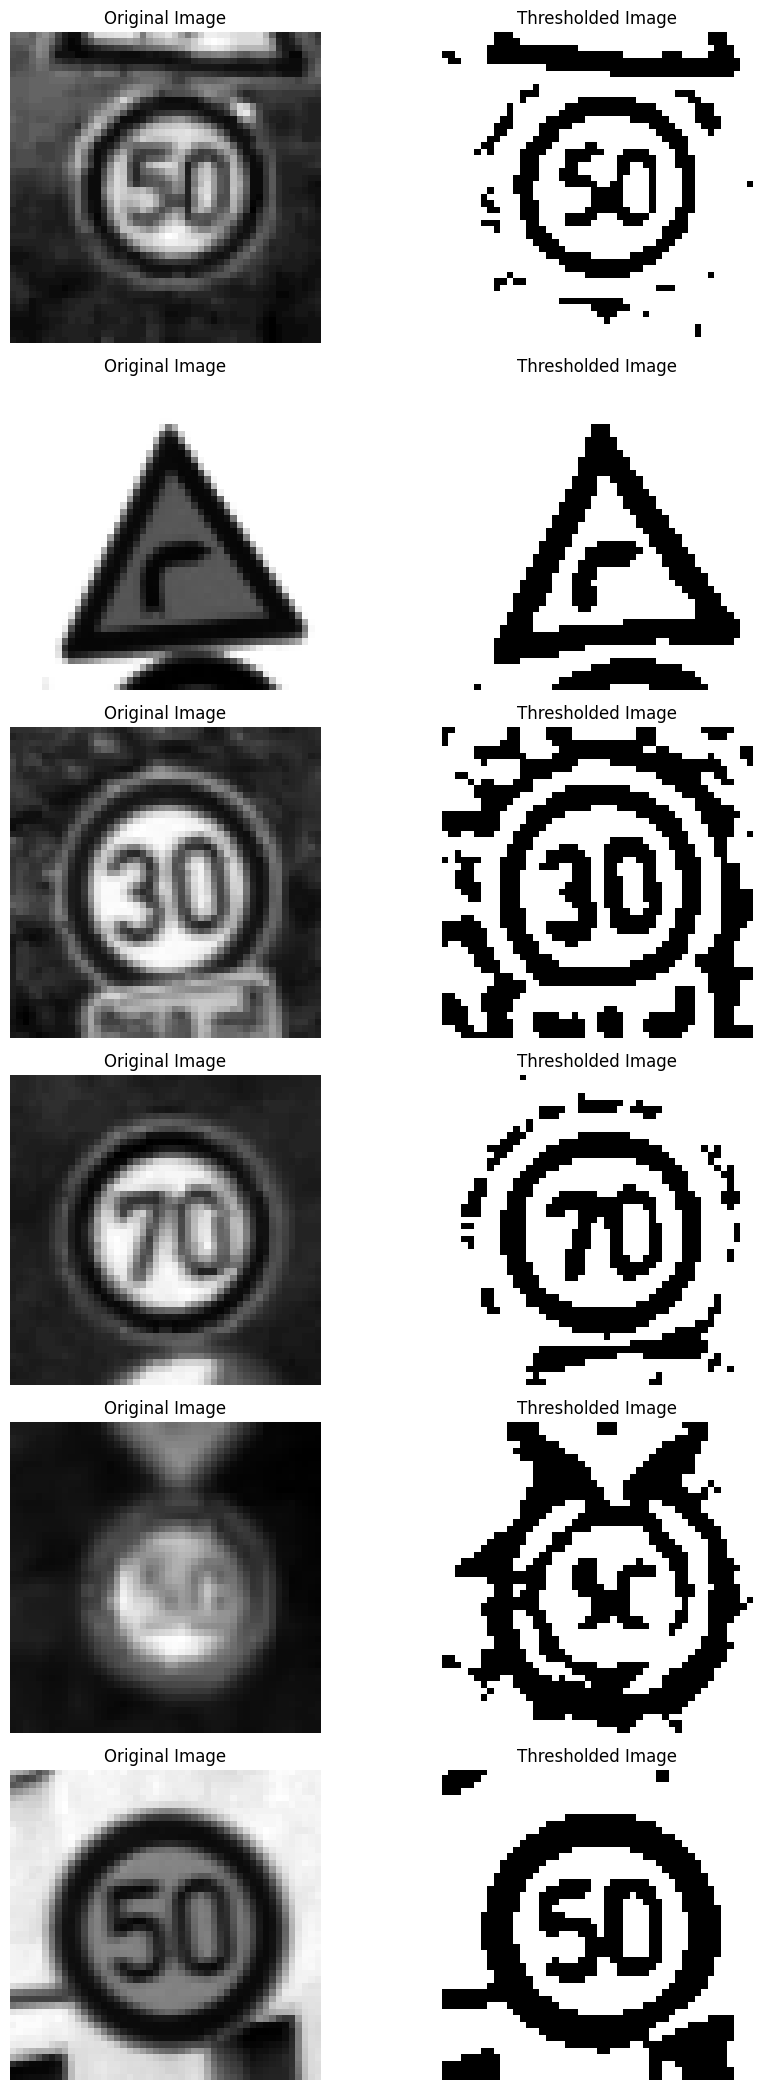

In [ ]:
# Randomly selecting indices for visualization
random_indices = random.sample(range(x_train_array.shape[0]), 6)

def visualize_images(original, thresholded, indices, image_shape):
    fig, axes = plt.subplots(len(indices), 2, figsize=(10, len(indices) * 3.5))

    for i, idx in enumerate(indices):
        # Original Image
        original_image = original[idx].reshape(image_shape)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Thresholded Image
        thresholded_image = thresholded[idx].reshape(image_shape)
        axes[i, 1].imshow(thresholded_image, cmap='gray')
        axes[i, 1].set_title('Thresholded Image')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the images
visualize_images(x_train_array, thresholded_x_train, random_indices, (48, 48))

## **Creating Functions for Displaying results**

### Function to Generate the ROC Curves for every class

In [ ]:
def gen_roc(y_prob, y_test, n_classes=10):

    # Initializing dictionaries to store the False Positive Rate (FPR), True Positive Rate (TPR) for each class and AUC (Area Under Curve)
    false_positive_rate = dict()
    true_positive_rate = dict()
    area_under_curve = dict()
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink', 'orange']
    # Creating OnevrsAll for all the classes of the dataset
    create_onevrsalls = pd.get_dummies(y_test, drop_first=False).values

    # Calculate TPR, FPR, and AUC for each class.
    for i in range(n_classes):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(create_onevrsalls[:, i], y_prob[:, i])
        area_under_curve[i] = auc(false_positive_rate[i], true_positive_rate[i])

    # Initialize the plotting figure.
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plotting a diagonal line, which represents a random classifier and setting x,y limits, labels, title, legend and gridlines
    ax.plot([0, 1], [0, 1], linestyle='--')
     # Plotting the ROC curve for each class.
    for i in range(n_classes):
        ax.plot(false_positive_rate[i], true_positive_rate[i], color=colors[i], label='ROC curve (area = %0.2f) for label %i' % (area_under_curve[i], i))

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="best")
    sns.despine()



    # Displaying the plot
    plt.show()

### Function to generate the Macro Averaged ROC Curve

In [ ]:
def plot_multiclass_roc_with_macro_avg(y_true, y_score_list, class_names, model_names, figsize=(10, 5)):

    # Determining the number of classes
    n_classes = len(class_names)

    plt.figure(figsize=figsize)

    # Binarize the true labels in a one-vs-all fashion for multiclass evaluation
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Iterating over each models score list
    for idx, y_score in enumerate(y_score_list):
        fpr_list = []
        tpr_list = []

        # Calculating FPR and TPR for each class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            fpr_list.append(fpr)
            tpr_list.append(tpr)

        # Calculating macro-average ROC curve by first finding all unique FPR values
        all_fpr = np.unique(np.concatenate(fpr_list))

        # Interpolating all ROC curves at these points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr_list[i], tpr_list[i])

        # Averaging the interpolated TPRs
        mean_tpr /= n_classes

        # Calculating the AUC for the macro-average ROC
        roc_auc_macro = auc(all_fpr, mean_tpr)

        # Plot the macro-average ROC curve for the current model
        plt.plot(all_fpr, mean_tpr, label=f'{model_names[idx]}, Macro-average ROC curve (area = {roc_auc_macro:0.2f})', linestyle='-', linewidth=2)

    # Plot the random guessing line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    # Configure plot settings
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-averaged ROC curve')
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

### Function to display the Training and Testing Accuracies

In [ ]:
def display_accuracies(clf, x_train, y_train, x_test, y_test):
  train_score = clf.score(x_train,y_train)
  test_score = clf.score(x_test,y_test)
  difference = train_score - test_score

  print("Accuracy on training set:",str(train_score))
  print("Accuracy on testing set:",str(test_score))
  print("Difference:",str(difference))

### Function to display the FPR and TPR

In [ ]:
def display_TPR_FPR(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)

  FP = cm.sum(axis=0) - np.diag(cm)
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  print(f"True Positive Rate: {TPR}")

  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  print(f"False Positive Rate: {FPR}")

  # Calculate the average TPR and FPR
  avg_TPR = np.mean(TPR)
  avg_FPR = np.mean(FPR)

  # Print the average TPR and FPR
  print(f"Average True Positive Rate: {avg_TPR}")
  print(f"Average False Positive Rate: {avg_FPR}")

### Function to Display the Confusion Matrix

In [ ]:
class_names = [str(i) for i in range(10)]
def confusion_matrix_display(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred, display_labels = class_names, cmap="Greens")
  plt.show()

### Function to combine all results and print them together

Print result function for traditional approaches

In [ ]:
def print_result(clf, x_train, y_train, x_test=None, y_test=None):
  if(x_test is None or y_test is None):
    x_test = x_train
    y_test = y_train
  y_pred = clf.predict(x_test)
  y_pred_proba = clf.predict_proba(x_test)
  print(classification_report(y_test, y_pred))
  print()
  confusion_matrix_display(y_test, y_pred)
  print()
  print("ROC Curve ")
  gen_roc(y_pred_proba, y_test)
  print()
  print("Macro Averaged ROC Curve: ")
  plot_multiclass_roc_with_macro_avg(y_test, [y_pred_proba], class_names, ["model"])
  print()
  display_TPR_FPR(y_test, y_pred)
  print()
  display_accuracies(clf, x_train, y_train, x_test, y_test)



Print result function for aNN approaches

In [ ]:
def print_resultNN(model, x_train, y_train, x_test, y_test, class_names):
    # Make predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    all_fpr = np.linspace(0, 1, 100)

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(class_names)
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot all ROC curves
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.plot(all_fpr, mean_tpr, color='b', label=f'Macro-average ROC curve (area = {mean_auc:.2f})', lw=2, alpha=.8)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## **Linear Classifiers**

Linear classifiers are a class of models that make predictions based on a linear decision boundary. This means they separate different classes in a dataset using a straight line (in two dimensions), a plane (in three dimensions), or a hyperplane (in higher dimensions). The core principle behind these classifiers is that they use a linear combination of features to predict the output.

### Logistic Regression Classifier

Logistic Regression is a statistical method and machine learning algorithm used primarily for binary classification tasks, although it can be extended to multiclass classification as well.

In [ ]:
y_train, y_test = y_train_array.ravel(), y_test_array.ravel()

In [ ]:
# Normalizing
thresholded_x_train_normalized = thresholded_x_train / 255.0
thresholded_x_test_normalized = thresholded_x_test / 255.0

#### **Training the models**

In [ ]:
# Training linear classifier with 10-fold cross-validation
clf_with_cv = LogisticRegression(multi_class='ovr', solver='liblinear')
cross_val_scores = cross_val_score(clf_with_cv, thresholded_x_train_normalized, y_train, cv=10)

In [ ]:
# Training classifier without cross-validation
clf_without_cv = LogisticRegression(multi_class='ovr', solver='liblinear')
clf_without_cv.fit(thresholded_x_train_normalized, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

#### **Evaluating the Logistic Regression model with Cross-Validation**

In [ ]:
# Evaluating the classifier on both training (with cross-validation)
mean_cv_accuracy = cross_val_scores.mean()

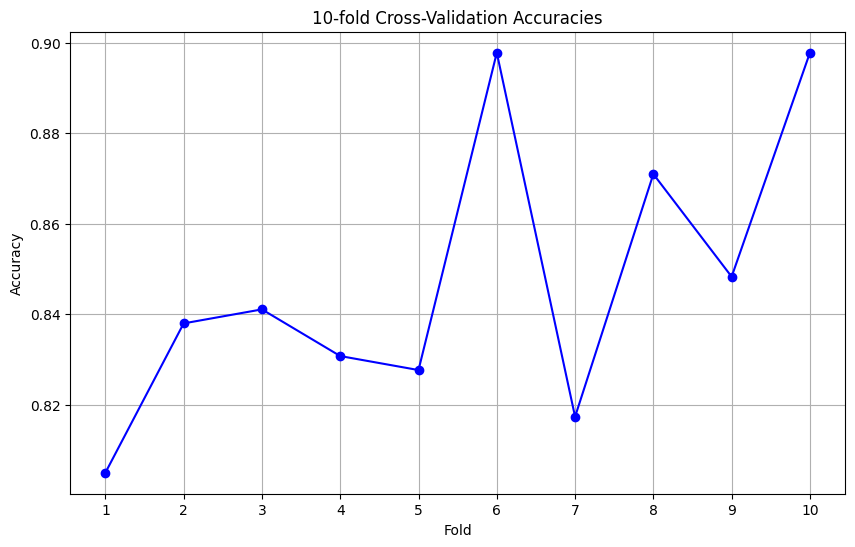

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cross_val_scores, marker='o', linestyle='-', color='b')
plt.title('10-fold Cross-Validation Accuracies')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))  # x-ticks to represent each fold
plt.grid(True)
plt.show()

#### **Evaluating the Logistic Regression model without Cross-Validation**

In [ ]:
y_pred_test = clf_without_cv.predict(thresholded_x_test_normalized)
y_pred_proba_test = clf_without_cv.predict_proba(thresholded_x_test_normalized)

              precision    recall  f1-score   support

           0       0.78      0.48      0.60        60
           1       0.83      0.86      0.85       720
           2       0.86      0.91      0.88       750
           3       0.83      0.84      0.83       450
           4       0.90      0.89      0.90       660
           5       0.90      0.87      0.88        60
           6       0.82      0.80      0.81        90
           7       0.94      0.55      0.69        60
           8       0.96      0.85      0.90       150
           9       0.87      0.82      0.85        90

    accuracy                           0.86      3090
   macro avg       0.87      0.79      0.82      3090
weighted avg       0.86      0.86      0.86      3090




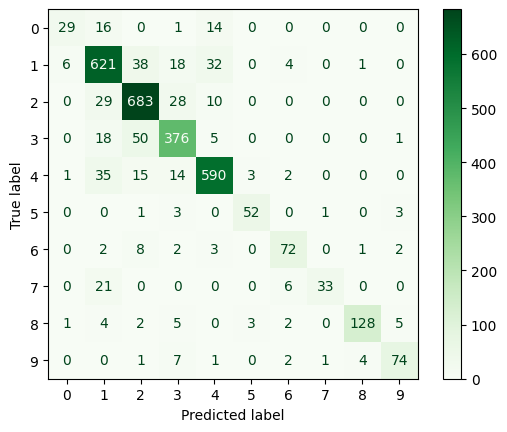


ROC Curve 


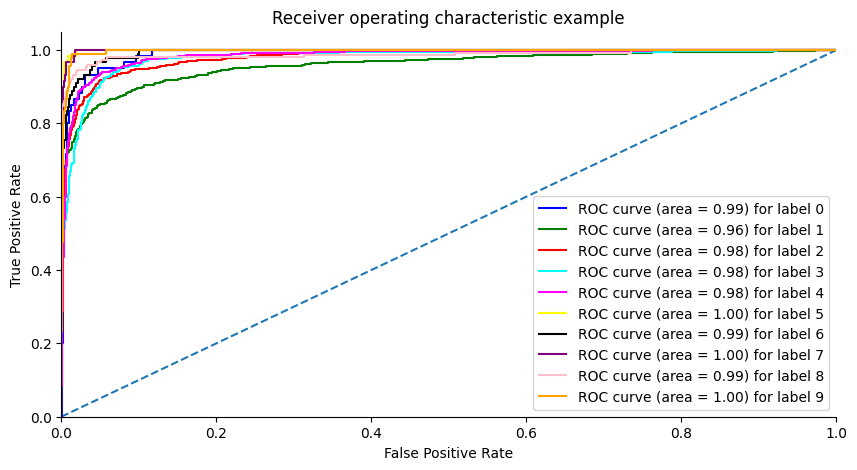


Macro Averaged ROC Curve: 


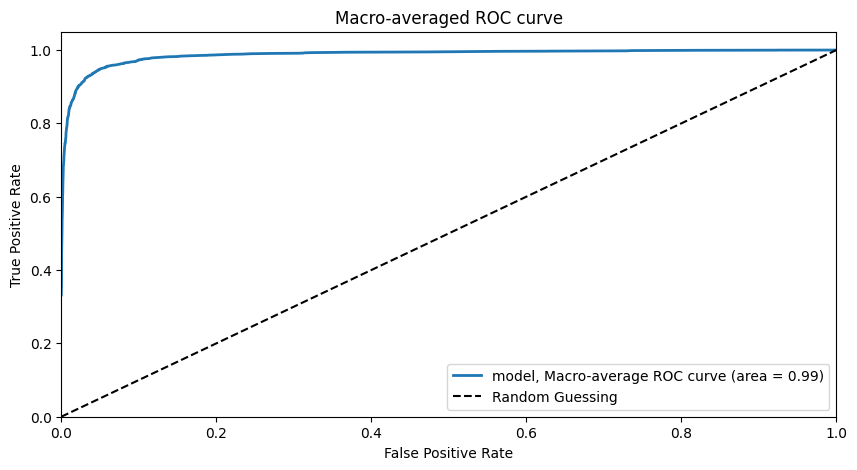


True Positive Rate: [0.48333333 0.8625     0.91066667 0.83555556 0.89393939 0.86666667
 0.8        0.55       0.85333333 0.82222222]
False Positive Rate: [0.00264026 0.05274262 0.0491453  0.02954545 0.02674897 0.0019802
 0.00533333 0.00066007 0.00204082 0.00366667]
Average True Positive Rate: 0.7878217171717172
Average False Positive Rate: 0.017450368529726052

Accuracy on training set: 0.9995872033023736
Accuracy on testing set: 0.8601941747572815
Difference: 0.13939302854509206


In [ ]:
print_result(clf_without_cv, thresholded_x_train_normalized, y_train, thresholded_x_test_normalized, y_test)

#### **Accuracy Comparison**

In [ ]:
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.2f}")
print(f"Accuracy without Cross-Validation Training Data: {clf_without_cv.score(thresholded_x_train_normalized, y_train)}")
print(f"Without Cross-Validation Accuracy: {accuracy_score(y_pred_test, y_test):.2f}")

Mean Cross-Validation Accuracy: 0.85
Accuracy without Cross-Validation Training Data: 0.9995872033023736
Without Cross-Validation Accuracy: 0.86


### Support Vector Machine (SVM)

Support Vector Machine (SVM) with a linear kernel, often referred to as Linear Support Vector Classification (Linear SVC), is a popular machine learning algorithm used for classification tasks. It's a specific implementation of SVM, a powerful and versatile machine learning model, especially useful in scenarios with high-dimensional data and a linear decision boundary. It's known for its robustness and the ability to handle complex datasets where the number of features is high.

#### **Training the models**

In [ ]:
# Training SVM classifier with 10-fold cross-validation
svm_with_cv = SVC(kernel='linear')
svm_cv_scores = cross_val_score(svm_with_cv, thresholded_x_train_normalized, y_train, cv=10)

In [ ]:
# Training SVM classifier without cross-validation
svm_without_cv = SVC(kernel='linear')
svm_without_cv.fit(thresholded_x_train_normalized, y_train)

SVC(kernel='linear')

#### **Evaluating the Logistic Regression model with Cross-Validation**

In [ ]:
# Evaluating the classifier with cross-validation
mean_svm_cv_accuracy = svm_cv_scores.mean()

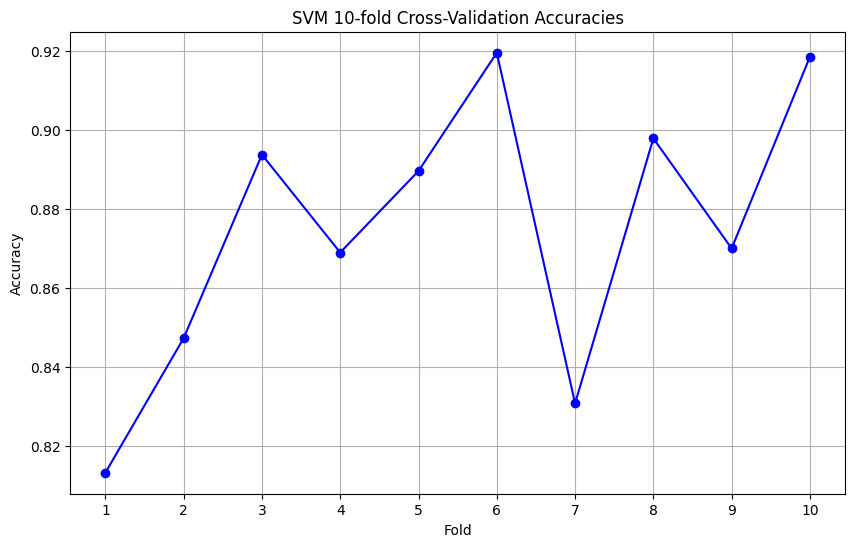

In [ ]:
# Plotting cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), svm_cv_scores, marker='o', linestyle='-', color='b')
plt.title('SVM 10-fold Cross-Validation Accuracies')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))  # x-ticks to represent each fold
plt.grid(True)
plt.show()

#### **Accuracies Comparison**

In [ ]:
# Making predictions on the test set
y_pred_test_svm = svm_without_cv.predict(thresholded_x_test_normalized)

In [ ]:
print(f"Mean SVM Cross-Validation Accuracy: {mean_svm_cv_accuracy:.2f}")
print(f"SVM Accuracy without Cross-Validation Training Data: {svm_without_cv.score(thresholded_x_train_normalized, y_train)}")
print(f"SVM Accuracy without Cross-Validation Test Data: {accuracy_score(y_test, y_pred_test_svm):.2f}")

Mean SVM Cross-Validation Accuracy: 0.87
SVM Accuracy without Cross-Validation Training Data: 1.0
SVM Accuracy without Cross-Validation Test Data: 0.89


##Multi-Layer Perceptron

## Neural Network Tuning and Visualization

### MLP Hyperparameter Tuning
The code segment initiates the tuning process for a Multi-Layer Perceptron (MLP) using Keras Tuner.

- **Model Definition**: Defines an MLP structure using `Sequential` model in Keras.
- **Hyperparameter Tuning**: Utilizes `RandomSearch` tuner to search for optimal hyperparameters.
- **Tuning Objective**: Maximizes validation accuracy over a range of hyperparameters.

### Best Model Evaluation
- **Model Evaluation**: Retrieves the best model obtained during hyperparameter tuning.
- **Test Set Evaluation**: Evaluates the best model's performance on the test set.

### Visualization of Hyperparameter Trials
- **Hyperparameter vs. Validation Accuracy**: Generates scatter plots for units, learning rates, and their impact on validation accuracy.

### Final Model Training
- **Training with Optimal Hyperparameters**: Reconstructs the model using the best hyperparameters and trains it on the data.
- **Training Metrics Visualization**: Displays accuracy and loss curves for both training and validation sets across epochs.


The output of the tuning process got a validation accuracy of 89.68%. Upon evaluating the model on the test set, an accuracy of 90% was attained. Furthermore, it was noted as the number of units in the first layer increased, the validation accuracy also increased, suggesting that a larger first layer might provide better performance in our dataset. We also noted that the validation accuracy decreased as the learning rate increased, this could indicate that a smaller learning rate might be more suitable.

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(48, 48, 1)))

    # Tuning the number of hidden layers and units in each layer
    for i in range(hp.Int('num_hidden_layers', 1, 5)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                        activation=hp.Choice('activation', values=['relu', 'tanh'])))

    model.add(Dense(10, activation='softmax'))

    # Tuning the learning rate for the optimizer
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    momentum = hp.Float('momentum', min_value=0.5, max_value=0.9, step=0.1)  # Tuning momentum
    model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

X_train, X_test, y_train, y_test = thresholded_x_train_normalized, thresholded_x_test_normalized, y_train_one_hot, y_test_one_hot

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mlp_tuning1'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

best_model = tuner.get_best_models(num_models=1)[0]
print(best_model.summary())
test_accuracy = best_model.evaluate(X_test, y_test)[1]
print(f"Test Set Accuracy: {test_accuracy:.2f}")

Trial 30 Complete [00h 00m 54s]
val_accuracy: 0.7938511371612549

Best val_accuracy So Far: 0.9003236293792725
Total elapsed time: 00h 29m 10s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 96)                221280    
                                                                 
 dense_1 (Dense)             (None, 192)               18624     
                                                                 
 dense_2 (Dense)             (None, 10)                1930      
                                                                 
Total params: 241834 (944.66 KB)
Trainable params: 241834 (944.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


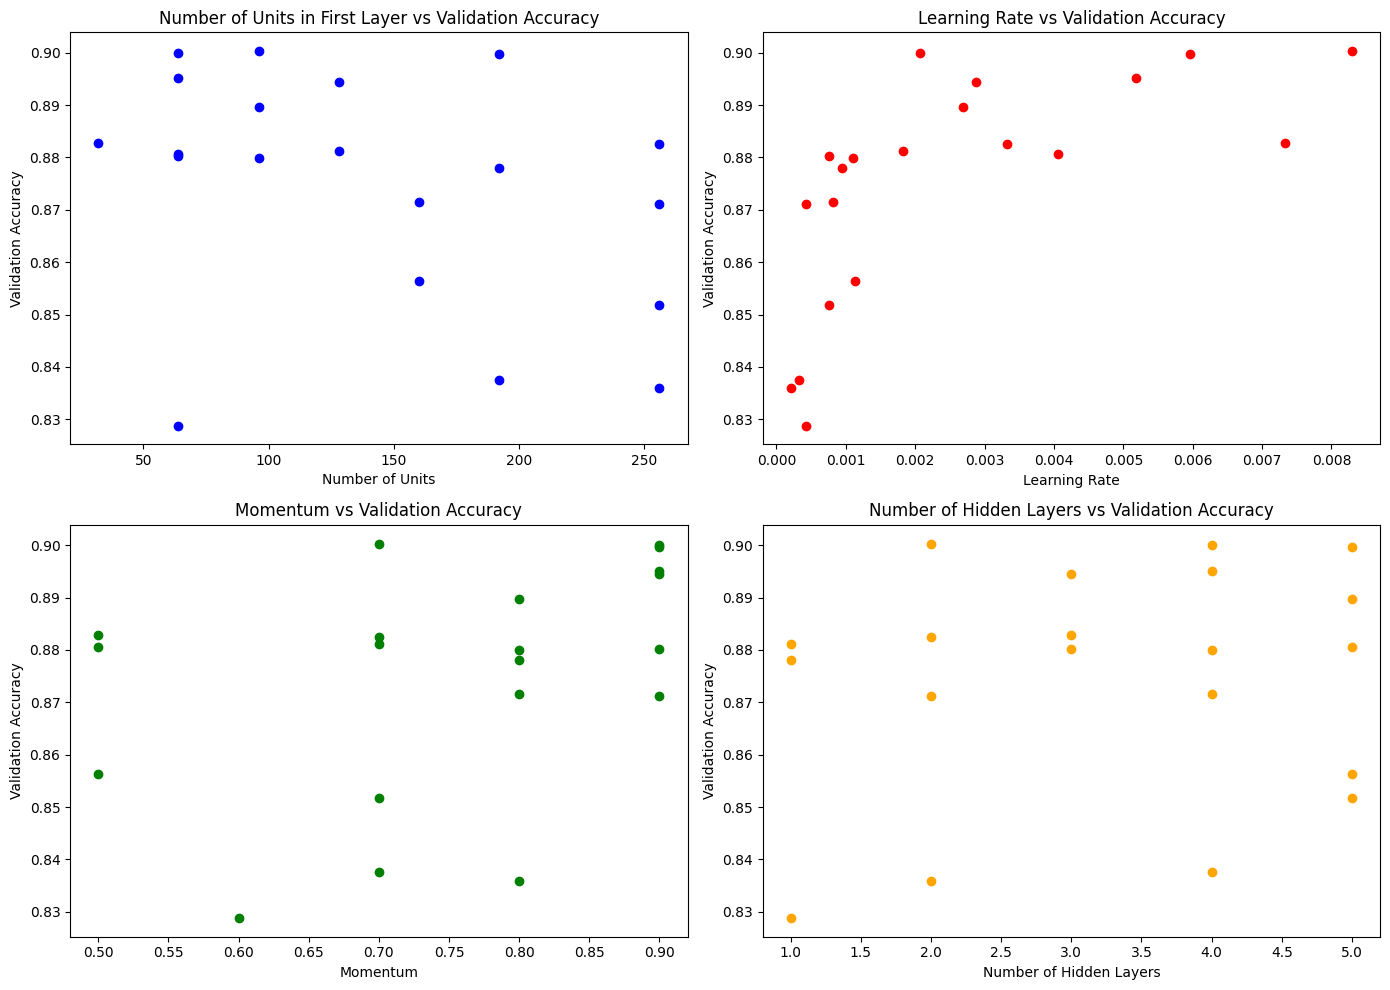

In [ ]:
# Extracting trials information
trials = tuner.oracle.get_best_trials(num_trials=20)

# Preparing data for plotting
units_list = []
learning_rate_list = []
momentum_list = []
num_hidden_layers_list = []
activation_functions_list = []
val_accuracy_list = []

for trial in trials:
    hps = trial.hyperparameters
    units_list.append(hps.get('units_0'))
    learning_rate_list.append(hps.get('learning_rate'))
    momentum_list.append(hps.get('momentum'))  # The possibly tuned hyperparameter Momentum
    num_hidden_layers_list.append(hps.get('num_hidden_layers'))  # A possibly tuned hyperparameter
    activation_functions_list.append(hps.get('activation'))  # The possibly tuned hyperparameter Activation function
    val_accuracy_list.append(trial.score)

# Plotting
plt.figure(figsize=(14, 10))

# Plotting units vs. validation accuracy
plt.subplot(2, 2, 1)
plt.scatter(units_list, val_accuracy_list, color='blue')
plt.title('Number of Units in First Layer vs Validation Accuracy')
plt.xlabel('Number of Units')
plt.ylabel('Validation Accuracy')

# Plotting learning rate vs. validation accuracy
plt.subplot(2, 2, 2)
plt.scatter(learning_rate_list, val_accuracy_list, color='red')
plt.title('Learning Rate vs Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')

# Plotting momentum vs. validation accuracy
plt.subplot(2, 2, 3)
plt.scatter(momentum_list, val_accuracy_list, color='green')
plt.title('Momentum vs Validation Accuracy')
plt.xlabel('Momentum')
plt.ylabel('Validation Accuracy')

# Plotting number of hidden layers vs. validation accuracy
plt.subplot(2, 2, 4)
plt.scatter(num_hidden_layers_list, val_accuracy_list, color='orange')
plt.title('Number of Hidden Layers vs Validation Accuracy')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()


In [ ]:
# Finding the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Building the model with the best hyperparameters and train it on the data
model = build_model(best_hps)
history = model.fit(X_train, y_train, epochs=30, callbacks=[early_stopping])


Epoch 1/30
91/97 [===========================>..] - ETA: 0s - loss: 1.4701 - accuracy: 0.4770

97/97 [==============================] - 2s 10ms/step - loss: 1.4426 - accuracy: 0.4880
Epoch 2/30
94/97 [============================>.] - ETA: 0s - loss: 0.7264 - accuracy: 0.7576

97/97 [==============================] - 1s 9ms/step - loss: 0.7195 - accuracy: 0.7602
Epoch 3/30
96/97 [============================>.] - ETA: 0s - loss: 0.4492 - accuracy: 0.8516

97/97 [==============================] - 1s 8ms/step - loss: 0.4488 - accuracy: 0.8521
Epoch 4/30
92/97 [===========================>..] - ETA: 0s - loss: 0.2768 - accuracy: 0.9198

97/97 [==============================] - 1s 8ms/step - loss: 0.2773 - accuracy: 0.9201
Epoch 5/30
94/97 [============================>.] - ETA: 0s - loss: 0.1897 - accuracy: 0.9471

97/97 [==============================] - 1s 7ms/step - loss: 0.1879 - accuracy: 0.9476
Epoch 6/30
95/97 [============================>.] - ETA: 0s - loss: 0.1521 - accuracy: 0.9622

97/97 [==============================] - 1s 6ms/step - loss: 0.1510 - accuracy: 0.9625
Epoch 7/30
92/97 [===========================>..] - ETA: 0s - loss: 0.0843 - accuracy: 0.9834

97/97 [==============================] - 1s 6ms/step - loss: 0.0863 - accuracy: 0.9825
Epoch 8/30
96/97 [============================>.] - ETA: 0s - loss: 0.0669 - accuracy: 0.9857

97/97 [==============================] - 1s 9ms/step - loss: 0.0667 - accuracy: 0.9858
Epoch 9/30
95/97 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9862

97/97 [==============================] - 1s 10ms/step - loss: 0.0594 - accuracy: 0.9864
Epoch 10/30
95/97 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9931

97/97 [==============================] - 1s 9ms/step - loss: 0.0383 - accuracy: 0.9932
Epoch 11/30
93/97 [===========================>..] - ETA: 0s - loss: 0.0232 - accuracy: 0.9983

97/97 [==============================] - 1s 8ms/step - loss: 0.0231 - accuracy: 0.9984
Epoch 12/30
92/97 [===========================>..] - ETA: 0s - loss: 0.0185 - accuracy: 0.9986

97/97 [==============================] - 1s 7ms/step - loss: 0.0182 - accuracy: 0.9987
Epoch 13/30
95/97 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9980

97/97 [==============================] - 1s 7ms/step - loss: 0.0189 - accuracy: 0.9981
Epoch 14/30
92/97 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 1.0000

97/97 [==============================] - 1s 7ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 15/30
93/97 [===========================>..] - ETA: 0s - loss: 0.0095 - accuracy: 0.9997

97/97 [==============================] - 1s 5ms/step - loss: 0.0095 - accuracy: 0.9997
Epoch 16/30
91/97 [===========================>..] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000

97/97 [==============================] - 1s 6ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 17/30
97/97 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 1.0000

97/97 [==============================] - 1s 7ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 18/30
97/97 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000

97/97 [==============================] - 1s 7ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 19/30
87/97 [=========================>....] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

97/97 [==============================] - 1s 5ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 20/30
97/97 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

97/97 [==============================] - 1s 6ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 21/30
92/97 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

97/97 [==============================] - 1s 7ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 22/30
91/97 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

97/97 [==============================] - 1s 7ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 23/30
95/97 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

97/97 [==============================] - 1s 6ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 24/30
97/97 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

97/97 [==============================] - 1s 6ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 25/30
91/97 [===========================>..] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

97/97 [==============================] - 1s 5ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 26/30
88/97 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

97/97 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 27/30
94/97 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

97/97 [==============================] - 1s 6ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 28/30
96/97 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

97/97 [==============================] - 1s 9ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 29/30
97/97 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

97/97 [==============================] - 1s 9ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 30/30
93/97 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

97/97 [==============================] - 1s 11ms/step - loss: 0.0027 - accuracy: 1.0000


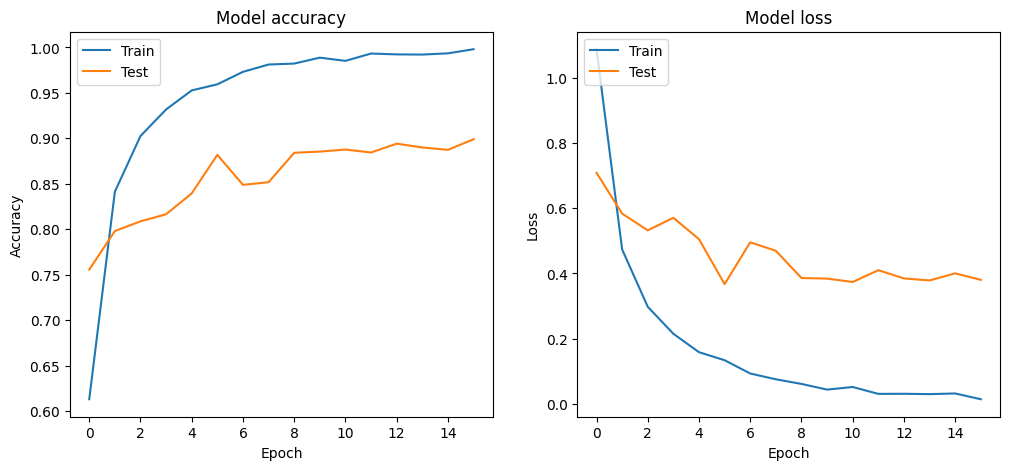

In [ ]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

97/97 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.62      0.73        60
           1       0.91      0.92      0.91       720
           2       0.89      0.96      0.92       750
           3       0.92      0.85      0.89       450
           4       0.92      0.93      0.93       660
           5       0.85      0.97      0.91        60
           6       0.81      0.71      0.76        90
           7       0.90      0.58      0.71        60
           8       0.94      0.88      0.91       150
           9       0.77      0.88      0.82        90

    accuracy                           0.90      3090
   macro avg       0.88      0.83      0.85      3090
weighted avg       0.90      0.90      0.90      3090


Confusion Matrix:


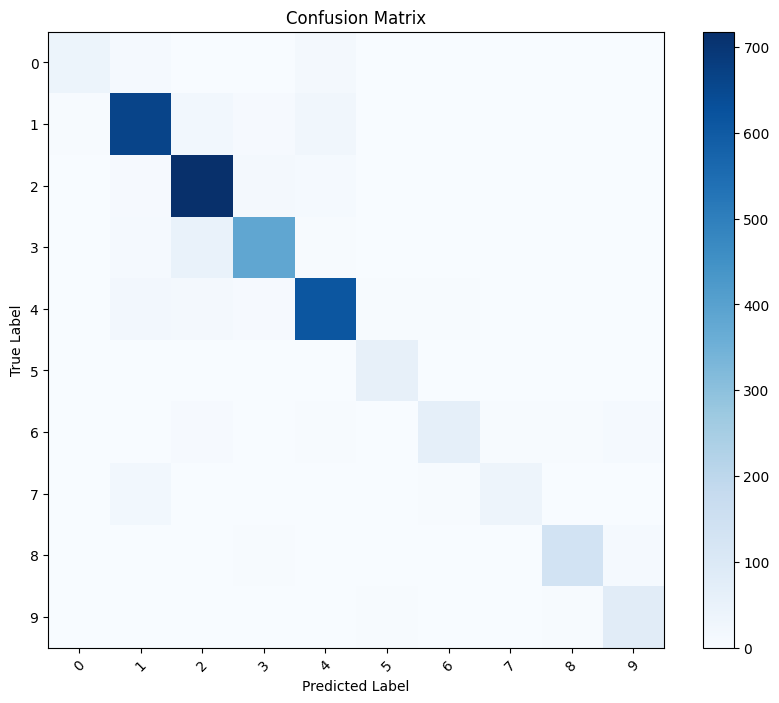

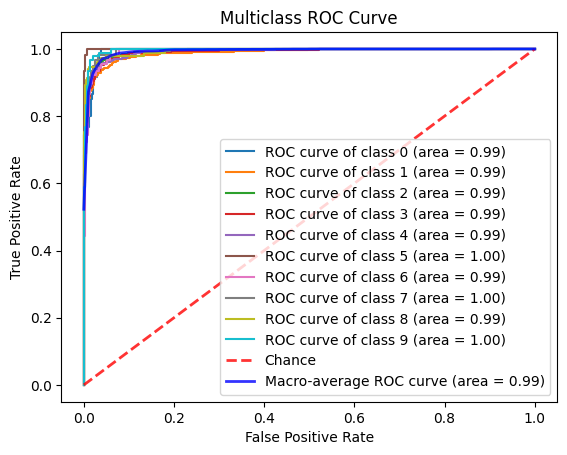

In [ ]:
best_model = keras.models.load_model('/content/drive/MyDrive/F20DL_Data/Models/mlp_best_model.keras')
print_resultNN(best_model, X_train, y_train, X_test, y_test, class_names)

## Convolutional Neural Network (CNN) Tuning

### Data Preparation
The provided code segment prepares the data for CNN training by reshaping and normalizing the input images. Additionally, it performs one-hot encoding on the labels to suit the model's requirements.

### CNN Model Architecture Tuning

### Model Building Function
The code defines a model-building function for the Keras Tuner that constructs a CNN with varying architecture:

- **Convolutional Layers**: Dynamically adds convolutional layers with adjustable filter sizes and kernel choices.
- **Pooling Layers**: Utilizes max pooling with a fixed pool size.
- **Dense Layers**: Incorporates densely connected layers with adjustable units.

### Hyperparameter Tuning
- **Objective**: Seeks to maximize validation accuracy using RandomSearch tuner.
- **Hyperparameters**: Tunes parameters such as convolutional layer filters, kernel sizes, dense layer units, learning rate, and momentum.

### Model Evaluation and Results

### Output Details
The tuning process's output details show the progress and the best achieved validation accuracy:

- **Best Validation Accuracy**: Peaks at 98.12% after running 20 trials.
- **Test Set Accuracy**: The evaluated best model achieves an impressive 98% accuracy on the test set.
- **Cross-Validation**: The best model scores an average accuracy of 98.61% across 10 epochs with 5 k-folds.



In [ ]:
# Since CNNs require matrices as input

thresholded_x_train_cnn = thresholded_x_train.reshape(-1, 48, 48, 1)
thresholded_x_test_cnn = thresholded_x_test.reshape(-1, 48, 48, 1)
thresholded_x_train_normalized = thresholded_x_train_cnn / 255.0
thresholded_x_test_normalized = thresholded_x_test_cnn / 255.0

In [ ]:
# Since the output layer of the neural network (CNN) is in the form of a vector
# for the predicted class being 1 and the rest being 0
y_train_one_hot = to_categorical(y_train_array.ravel(), num_classes=10)
y_test_one_hot = to_categorical(y_test_array.ravel(), num_classes=10)

In [ ]:
X_train, X_test, y_train, y_test = thresholded_x_train_normalized, thresholded_x_test_normalized, y_train_one_hot, y_test_one_hot

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(48, 48, 1)))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('num_conv_layers', 1, 3)):  # Tuning the number of convolutional layers
        model.add(Conv2D(filters=hp.Int(f'conv_{i+2}_filters', min_value=32, max_value=256, step=32),
                         kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    for i in range(hp.Int('num_dense_layers', 1, 3)):  # Tuning the number of dense layers
        model.add(Dense(units=hp.Int(f'dense_{i}', min_value=32, max_value=256, step=32),
                        activation='relu'))

    model.add(Dense(10, activation='softmax'))

    # Tuning the learning rate for the optimizer
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    momentum = hp.Float('momentum', min_value=0.5, max_value=0.9, step=0.1)  # Tuning momentum
    model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of trials to run
    executions_per_trial=1,  # Number of models to train per trial
    directory='my_dir',  # Directory to save logs and models
    project_name='cnn_tuning'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Running the random search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Obtaining the best model and evaluating metrics
best_model = tuner.get_best_models(num_models=1)[0]
test_accuracy = best_model.evaluate(X_test, y_test)[1]
print(f"Test Set Accuracy: {test_accuracy:.2f}")


Trial 20 Complete [00h 01m 23s]
val_accuracy: 0.9624595642089844

Best val_accuracy So Far: 0.9812297821044922
Total elapsed time: 00h 27m 17s
97/97 [==============================] - 1s 6ms/step - loss: 0.0556 - accuracy: 0.9812
Test Set Accuracy: 0.98


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 224)       5824      
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 224)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 224)       1254624   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 224)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 96)          193632    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 96)          0

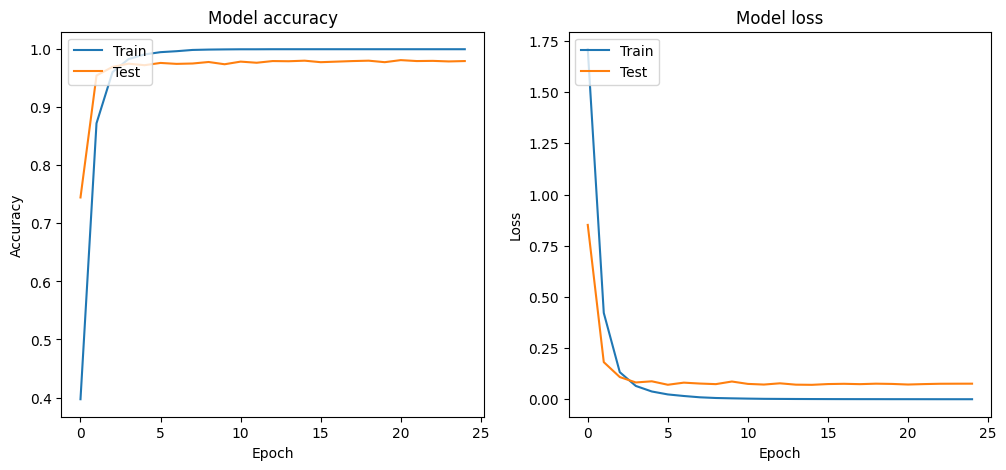

In [ ]:
print(best_model.summary())

# Finding the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Building the model with the best hyperparameters and train it on the data
model = build_model(best_hps)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

97/97 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        60
           1       0.99      0.99      0.99       720
           2       1.00      0.99      0.99       750
           3       0.99      1.00      0.99       450
           4       0.99      0.98      0.99       660
           5       1.00      1.00      1.00        60
           6       0.91      0.96      0.93        90
           7       1.00      0.72      0.83        60
           8       0.99      0.93      0.96       150
           9       0.80      1.00      0.89        90

    accuracy                           0.98      3090
   macro avg       0.96      0.95      0.95      3090
weighted avg       0.98      0.98      0.98      3090


Confusion Matrix:


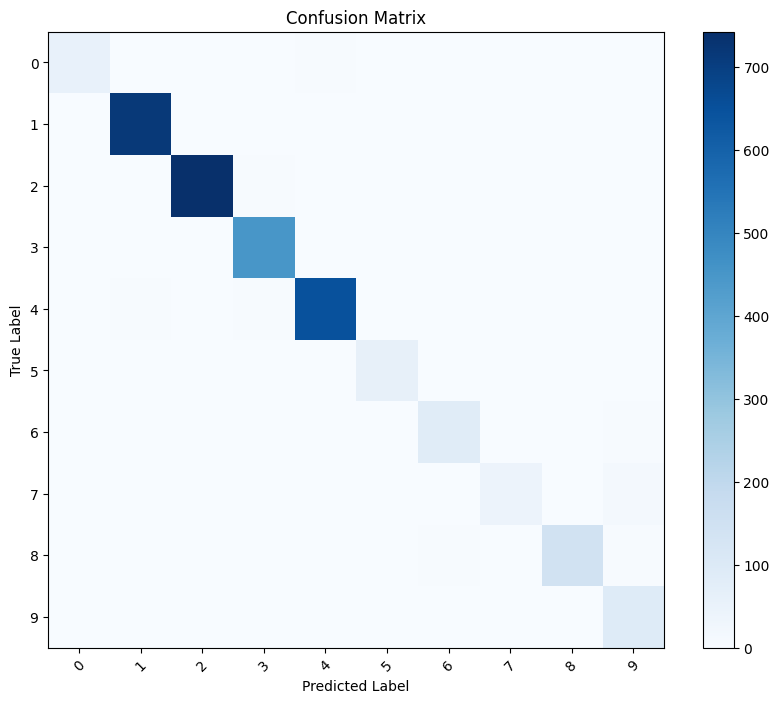

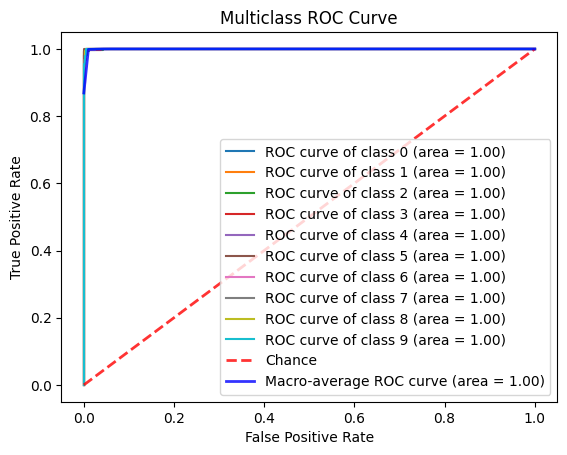

In [ ]:
print_resultNN(best_model, X_train, y_train, X_test, y_test, class_names)

In [ ]:
# Defining the number of splits for K-Fold cross-validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Preparing the data
X = thresholded_x_train_normalized
Y = to_categorical(y_train_array.ravel(), num_classes=10)

# Initializing scores record
accuracy_scores = []

# K-Fold Cross-Validation
for train, test in kfold.split(X, np.argmax(Y, axis=1)):
    # Creating a new instance of the model
    model = build_model(best_hps)

    # Training the model
    model.fit(X[train], Y[train], epochs=10, batch_size=32, verbose=0)  # Going with 10 epochs

    # Evaluating the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    accuracy_scores.append(scores[1] * 100)

# Calculating average scores
average_accuracy = np.mean(accuracy_scores)
print(f'Average Accuracy across all folds: {average_accuracy:.2f}%')


Average Accuracy across all folds: 98.61%


In [ ]:
best_model.save('/content/drive/MyDrive/F20DL_Data/Models/cnn_best_model.keras')